In [1]:
import os
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from PIL import Image
from torch.optim import Optimizer
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16
from tqdm import tqdm

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

TRAIN_BATCHSIZE = 128
TEST_BATCHSIZE = 64

dataset = MNIST('./data', transform=img_transform, download=True,)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [40000, 10000, 10000])

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TEST_BATCHSIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCHSIZE, shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {
            'kernel_size': (3, 3),
            'stride'     : (1, 1),
            'padding'   : 1
        }
        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)
        return x
    
class VGG16(nn.Module):
    def __init__(self, config):
        super(VGG16, self).__init__()
        self.config = config
        self.in_channels, self.in_width, self.in_height = config.input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=config.batch_norm)
        self.block_2 = VGGBlock(64, 128,batch_norm=config.batch_norm)
        self.block_3 = VGGBlock(128, 256,batch_norm=config.batch_norm)
        self.block_4 = VGGBlock(256,512,batch_norm=config.batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(256, 128),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(128, config.num_classes) 
            )

    @property
    def input_size(self):
        return self.in_channels,self.in_width,self.in_height

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x
    
    @staticmethod
    def _init_model_with_state_dict(state):
        model = VGG16(state['model_config'])
        model.load_state_dict(state['model_state_dict'])
        return model
    
    @classmethod
    def load(cls, path):
        r"""
        Loads a model with data fields and pretrained model parameters.
        Args:
            path (str):
                - a string with the shortcut name of a pretrained learner
                  to load from .pt file.
        Examples:
            >>> # model = VGG16.load('./tmp/resources/<model_name>.pt')
        """
        if os.path.exists(path):
            state = torch.load(path)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), path)
        model = cls._init_model_with_state_dict(state)
        return model

In [4]:

class AdamOptimizer(Optimizer):
    """
    implements ADAM Algorithm, as a preceding step.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamOptimizer, self).__init__(params, defaults)
        
    def step(self):
        import math
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:

            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Momentum (Exponential MA of gradients)
                    state['exp_avg'] = torch.zeros_like(p.data)
                    #print(p.data.size())
                    # RMS Prop componenet. (Exponential MA of squared gradients). Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2 penalty. Gotta add to Gradient as well.
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 

        return loss

class SgdOptimizer(Optimizer):
    """Implements SGD Algorithm
    The Nesterov version can be performed by choosing input argument
    """
    def __init__(self, 
        params, 
        lr=1e-3, 
        momentum=0, 
        dampening=0,
        weight_decay=0, 
        nesterov=False):

        defaults = dict(lr=lr, momentum=momentum,
                        dampening=dampening,
                        weight_decay=weight_decay, 
                        nesterov=nesterov)

        super(SgdOptimizer, self).__init__(params, defaults)

    def step(self):
        loss = None
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

In [5]:
class TrainingArgs:
    def __init__(self):
        self.lr = 1e-3
        self.num_epochs = 50
        self.input_size = (1,28,28)
        self.num_classes = 10
        self.batch_norm = True
        # self.pretrained = True
        self.nesterov = True
        self.weight_decay = 1e-5
        self.use_early_stopping = True
args = TrainingArgs()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16(args).to(device)

criterion = nn.CrossEntropyLoss()
optim = SgdOptimizer(model.parameters(), lr=args.lr, nesterov=args.nesterov, weight_decay=args.weight_decay)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters: ", count_parameters(model))

Total parameters:  4853578


In [8]:
history = {'acc': {'train': [], 'val': []}, 
    'loss': {'train': [], 'val': []}}
min_val_loss = np.inf

for epoch in range(args.num_epochs):
    # Training
    train_iterator = tqdm(train_loader, leave=True)
    running_train_loss = 0.0
    running_train_acc = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_iterator):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_acc = ((outputs.argmax(dim=1) == labels).float().mean())        
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Gather training loss and acc
        running_train_loss += loss.item()
        running_train_acc += train_acc.item()
        
        train_iterator.set_description('(Train) Epoch [{}/{}]'.format(epoch, args.num_epochs))
        train_iterator.set_postfix(train_loss=loss.item(), train_acc=train_acc.item())

    epoch_train_loss = running_train_loss/len(train_loader)
    epoch_train_acc = running_train_acc/len(train_loader)

    history['acc']['train'].append(epoch_train_acc)
    history['loss']['train'].append(epoch_train_loss)
    
    # Evaluation
    val_iterator = tqdm(val_loader, leave=True)
    running_val_loss = 0.0
    running_val_acc = 0.0
    model.eval()
    for vidx, (val_images, val_labels) in enumerate(val_iterator):
        with torch.no_grad():
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_acc = ((val_outputs.argmax(dim=1) == val_labels).float().mean())

            running_val_loss += val_loss.item()
            running_val_acc += val_acc.item()
            
            val_iterator.set_description('(Val) Epoch [{}/{}]'.format(epoch, args.num_epochs))
            val_iterator.set_postfix(val_loss=val_loss.item(), val_acc=val_acc.item())
            
    epoch_val_acc = running_val_acc/len(val_loader)
    epoch_val_loss = running_val_loss/len(val_loader)

    history['acc']['val'].append(epoch_val_acc)
    history['loss']['val'].append(epoch_val_loss)
    
    print(f'>> Epoch [{epoch+1}/{args.num_epochs}]:\tTrain loss = {epoch_train_loss:.5f} | Val loss = {epoch_val_loss:.5f},\
                \t Train Acc = {epoch_train_acc:.5f} | Val Acc = {epoch_val_acc:.5f}')
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        print(">> Saving The Model Checkpoint")
        torch.save(
            {
                'model_config': model.config,
                'model_state_dict': model.state_dict(),
                'optim_state_dict': optim.state_dict(),
                'history': history
            }, './vgg16-sgd-mnist.pt'
        )

  0%|          | 0/313 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1055.)
(Val) Epoch [0/50]: 100%|██████████| 157/157 [00:03<00:00, 46.83it/s, val_acc=0.562, val_loss=2]


>> Epoch [1/50]:	Train loss = 2.19815 | Val loss = 1.93989,                	 Train Acc = 0.20902 | Val Acc = 0.63854
>> Saving The Model Checkpoint


(Val) Epoch [1/50]: 100%|██████████| 157/157 [00:03<00:00, 50.98it/s, val_acc=0.75, val_loss=1.46]


>> Epoch [2/50]:	Train loss = 1.82579 | Val loss = 1.34378,                	 Train Acc = 0.41242 | Val Acc = 0.82733
>> Saving The Model Checkpoint


(Val) Epoch [2/50]: 100%|██████████| 157/157 [00:03<00:00, 46.10it/s, val_acc=1, val_loss=0.843]


>> Epoch [3/50]:	Train loss = 1.37386 | Val loss = 0.78833,                	 Train Acc = 0.58768 | Val Acc = 0.92088
>> Saving The Model Checkpoint


(Val) Epoch [3/50]: 100%|██████████| 157/157 [00:03<00:00, 51.94it/s, val_acc=1, val_loss=0.446]


>> Epoch [4/50]:	Train loss = 0.98781 | Val loss = 0.42935,                	 Train Acc = 0.71937 | Val Acc = 0.95034
>> Saving The Model Checkpoint


(Val) Epoch [4/50]: 100%|██████████| 157/157 [00:02<00:00, 52.79it/s, val_acc=1, val_loss=0.25]


>> Epoch [5/50]:	Train loss = 0.72550 | Val loss = 0.25456,                	 Train Acc = 0.79927 | Val Acc = 0.96139
>> Saving The Model Checkpoint


(Val) Epoch [5/50]: 100%|██████████| 157/157 [00:03<00:00, 48.52it/s, val_acc=0.938, val_loss=0.179]


>> Epoch [6/50]:	Train loss = 0.55188 | Val loss = 0.17324,                	 Train Acc = 0.85271 | Val Acc = 0.96746
>> Saving The Model Checkpoint


(Val) Epoch [6/50]: 100%|██████████| 157/157 [00:03<00:00, 52.14it/s, val_acc=0.938, val_loss=0.145]


>> Epoch [7/50]:	Train loss = 0.43987 | Val loss = 0.13106,                	 Train Acc = 0.88576 | Val Acc = 0.97174
>> Saving The Model Checkpoint


(Val) Epoch [7/50]: 100%|██████████| 157/157 [00:03<00:00, 47.21it/s, val_acc=0.938, val_loss=0.119]


>> Epoch [8/50]:	Train loss = 0.36831 | Val loss = 0.10518,                	 Train Acc = 0.90650 | Val Acc = 0.97472
>> Saving The Model Checkpoint


(Val) Epoch [8/50]: 100%|██████████| 157/157 [00:02<00:00, 53.87it/s, val_acc=0.938, val_loss=0.138]


>> Epoch [9/50]:	Train loss = 0.31387 | Val loss = 0.08917,                	 Train Acc = 0.91873 | Val Acc = 0.97711
>> Saving The Model Checkpoint


(Val) Epoch [9/50]: 100%|██████████| 157/157 [00:03<00:00, 51.91it/s, val_acc=0.938, val_loss=0.133]


>> Epoch [10/50]:	Train loss = 0.27153 | Val loss = 0.07923,                	 Train Acc = 0.93094 | Val Acc = 0.97880
>> Saving The Model Checkpoint


(Val) Epoch [10/50]: 100%|██████████| 157/157 [00:03<00:00, 49.75it/s, val_acc=0.938, val_loss=0.135]


>> Epoch [11/50]:	Train loss = 0.23786 | Val loss = 0.07200,                	 Train Acc = 0.93982 | Val Acc = 0.97900
>> Saving The Model Checkpoint


(Val) Epoch [11/50]: 100%|██████████| 157/157 [00:03<00:00, 51.75it/s, val_acc=0.938, val_loss=0.143]


>> Epoch [12/50]:	Train loss = 0.21842 | Val loss = 0.06531,                	 Train Acc = 0.94631 | Val Acc = 0.98159
>> Saving The Model Checkpoint


(Val) Epoch [12/50]: 100%|██████████| 157/157 [00:02<00:00, 52.51it/s, val_acc=0.938, val_loss=0.166]


>> Epoch [13/50]:	Train loss = 0.19623 | Val loss = 0.06130,                	 Train Acc = 0.95028 | Val Acc = 0.98229
>> Saving The Model Checkpoint


(Val) Epoch [13/50]: 100%|██████████| 157/157 [00:03<00:00, 49.37it/s, val_acc=0.938, val_loss=0.142]


>> Epoch [14/50]:	Train loss = 0.18088 | Val loss = 0.05733,                	 Train Acc = 0.95545 | Val Acc = 0.98348
>> Saving The Model Checkpoint


(Val) Epoch [14/50]: 100%|██████████| 157/157 [00:03<00:00, 44.57it/s, val_acc=0.938, val_loss=0.145]


>> Epoch [15/50]:	Train loss = 0.16408 | Val loss = 0.05408,                	 Train Acc = 0.95986 | Val Acc = 0.98408
>> Saving The Model Checkpoint


(Val) Epoch [15/50]: 100%|██████████| 157/157 [00:02<00:00, 53.01it/s, val_acc=0.938, val_loss=0.156]


>> Epoch [16/50]:	Train loss = 0.15261 | Val loss = 0.05230,                	 Train Acc = 0.96261 | Val Acc = 0.98487
>> Saving The Model Checkpoint


(Val) Epoch [16/50]: 100%|██████████| 157/157 [00:03<00:00, 49.83it/s, val_acc=0.938, val_loss=0.173]


>> Epoch [17/50]:	Train loss = 0.14276 | Val loss = 0.04920,                	 Train Acc = 0.96563 | Val Acc = 0.98597
>> Saving The Model Checkpoint


(Val) Epoch [17/50]: 100%|██████████| 157/157 [00:03<00:00, 51.74it/s, val_acc=0.938, val_loss=0.172]


>> Epoch [18/50]:	Train loss = 0.13006 | Val loss = 0.04869,                	 Train Acc = 0.96733 | Val Acc = 0.98637
>> Saving The Model Checkpoint


(Val) Epoch [18/50]: 100%|██████████| 157/157 [00:03<00:00, 52.19it/s, val_acc=0.938, val_loss=0.185]


>> Epoch [19/50]:	Train loss = 0.12328 | Val loss = 0.04716,                	 Train Acc = 0.97090 | Val Acc = 0.98637
>> Saving The Model Checkpoint


(Val) Epoch [19/50]: 100%|██████████| 157/157 [00:03<00:00, 48.50it/s, val_acc=0.938, val_loss=0.147]


>> Epoch [20/50]:	Train loss = 0.11602 | Val loss = 0.04441,                	 Train Acc = 0.97279 | Val Acc = 0.98716
>> Saving The Model Checkpoint


(Val) Epoch [20/50]: 100%|██████████| 157/157 [00:02<00:00, 53.20it/s, val_acc=0.938, val_loss=0.172]


>> Epoch [21/50]:	Train loss = 0.10884 | Val loss = 0.04390,                	 Train Acc = 0.97352 | Val Acc = 0.98726
>> Saving The Model Checkpoint


(Val) Epoch [21/50]: 100%|██████████| 157/157 [00:03<00:00, 43.77it/s, val_acc=0.938, val_loss=0.185]


>> Epoch [22/50]:	Train loss = 0.10115 | Val loss = 0.04298,                	 Train Acc = 0.97509 | Val Acc = 0.98736
>> Saving The Model Checkpoint


(Val) Epoch [22/50]: 100%|██████████| 157/157 [00:03<00:00, 50.76it/s, val_acc=0.938, val_loss=0.169]


>> Epoch [23/50]:	Train loss = 0.09638 | Val loss = 0.04273,                	 Train Acc = 0.97744 | Val Acc = 0.98746
>> Saving The Model Checkpoint


(Val) Epoch [23/50]: 100%|██████████| 157/157 [00:03<00:00, 51.50it/s, val_acc=0.938, val_loss=0.153]


>> Epoch [24/50]:	Train loss = 0.09142 | Val loss = 0.04029,                	 Train Acc = 0.97866 | Val Acc = 0.98816
>> Saving The Model Checkpoint


(Val) Epoch [24/50]: 100%|██████████| 157/157 [00:03<00:00, 50.04it/s, val_acc=0.938, val_loss=0.198]


>> Epoch [25/50]:	Train loss = 0.08444 | Val loss = 0.04146,                	 Train Acc = 0.97968 | Val Acc = 0.98776


(Val) Epoch [25/50]: 100%|██████████| 157/157 [00:03<00:00, 49.91it/s, val_acc=0.938, val_loss=0.185]


>> Epoch [26/50]:	Train loss = 0.07988 | Val loss = 0.04053,                	 Train Acc = 0.98098 | Val Acc = 0.98895


(Val) Epoch [26/50]: 100%|██████████| 157/157 [00:02<00:00, 52.82it/s, val_acc=0.938, val_loss=0.183]


>> Epoch [27/50]:	Train loss = 0.07928 | Val loss = 0.03976,                	 Train Acc = 0.98058 | Val Acc = 0.98816
>> Saving The Model Checkpoint


(Val) Epoch [27/50]: 100%|██████████| 157/157 [00:03<00:00, 52.30it/s, val_acc=0.938, val_loss=0.189]


>> Epoch [28/50]:	Train loss = 0.07003 | Val loss = 0.03949,                	 Train Acc = 0.98430 | Val Acc = 0.98915
>> Saving The Model Checkpoint


(Val) Epoch [28/50]: 100%|██████████| 157/157 [00:03<00:00, 51.73it/s, val_acc=0.938, val_loss=0.192]


>> Epoch [29/50]:	Train loss = 0.07077 | Val loss = 0.03965,                	 Train Acc = 0.98305 | Val Acc = 0.98826


(Val) Epoch [29/50]: 100%|██████████| 157/157 [00:03<00:00, 50.65it/s, val_acc=0.938, val_loss=0.184]


>> Epoch [30/50]:	Train loss = 0.06906 | Val loss = 0.03746,                	 Train Acc = 0.98423 | Val Acc = 0.98965
>> Saving The Model Checkpoint


(Val) Epoch [30/50]: 100%|██████████| 157/157 [00:03<00:00, 43.87it/s, val_acc=0.938, val_loss=0.227]


>> Epoch [31/50]:	Train loss = 0.06505 | Val loss = 0.03878,                	 Train Acc = 0.98470 | Val Acc = 0.98855


(Val) Epoch [31/50]: 100%|██████████| 157/157 [00:02<00:00, 52.58it/s, val_acc=0.938, val_loss=0.213]


>> Epoch [32/50]:	Train loss = 0.06234 | Val loss = 0.03845,                	 Train Acc = 0.98582 | Val Acc = 0.98895


(Val) Epoch [32/50]: 100%|██████████| 157/157 [00:03<00:00, 46.92it/s, val_acc=0.938, val_loss=0.197]


>> Epoch [33/50]:	Train loss = 0.05866 | Val loss = 0.03824,                	 Train Acc = 0.98657 | Val Acc = 0.98975


(Val) Epoch [33/50]: 100%|██████████| 157/157 [00:03<00:00, 44.64it/s, val_acc=0.938, val_loss=0.207]


>> Epoch [34/50]:	Train loss = 0.05566 | Val loss = 0.03809,                	 Train Acc = 0.98707 | Val Acc = 0.98955


(Val) Epoch [34/50]: 100%|██████████| 157/157 [00:03<00:00, 51.79it/s, val_acc=0.938, val_loss=0.208]


>> Epoch [35/50]:	Train loss = 0.05572 | Val loss = 0.03780,                	 Train Acc = 0.98740 | Val Acc = 0.98945


(Val) Epoch [35/50]: 100%|██████████| 157/157 [00:03<00:00, 51.25it/s, val_acc=0.938, val_loss=0.208]


>> Epoch [36/50]:	Train loss = 0.04947 | Val loss = 0.03750,                	 Train Acc = 0.98832 | Val Acc = 0.98955


(Val) Epoch [36/50]: 100%|██████████| 157/157 [00:03<00:00, 45.77it/s, val_acc=0.938, val_loss=0.194]


>> Epoch [37/50]:	Train loss = 0.05207 | Val loss = 0.03723,                	 Train Acc = 0.98692 | Val Acc = 0.98905
>> Saving The Model Checkpoint


(Val) Epoch [37/50]: 100%|██████████| 157/157 [00:02<00:00, 53.82it/s, val_acc=0.938, val_loss=0.222]


>> Epoch [38/50]:	Train loss = 0.04870 | Val loss = 0.03693,                	 Train Acc = 0.98829 | Val Acc = 0.98965
>> Saving The Model Checkpoint


(Val) Epoch [38/50]: 100%|██████████| 157/157 [00:02<00:00, 53.26it/s, val_acc=0.938, val_loss=0.212]


>> Epoch [39/50]:	Train loss = 0.04665 | Val loss = 0.03695,                	 Train Acc = 0.98914 | Val Acc = 0.98995


(Val) Epoch [39/50]: 100%|██████████| 157/157 [00:03<00:00, 48.87it/s, val_acc=0.938, val_loss=0.209]


>> Epoch [40/50]:	Train loss = 0.04474 | Val loss = 0.03716,                	 Train Acc = 0.98947 | Val Acc = 0.98995


(Val) Epoch [40/50]: 100%|██████████| 157/157 [00:03<00:00, 46.31it/s, val_acc=0.938, val_loss=0.197]


>> Epoch [41/50]:	Train loss = 0.04251 | Val loss = 0.03655,                	 Train Acc = 0.99084 | Val Acc = 0.99005
>> Saving The Model Checkpoint


(Val) Epoch [41/50]: 100%|██████████| 157/157 [00:03<00:00, 46.80it/s, val_acc=0.938, val_loss=0.185]


>> Epoch [42/50]:	Train loss = 0.04144 | Val loss = 0.03610,                	 Train Acc = 0.99034 | Val Acc = 0.98975
>> Saving The Model Checkpoint


(Val) Epoch [42/50]: 100%|██████████| 157/157 [00:03<00:00, 49.23it/s, val_acc=0.938, val_loss=0.204]


>> Epoch [43/50]:	Train loss = 0.03937 | Val loss = 0.03704,                	 Train Acc = 0.99094 | Val Acc = 0.99015


(Val) Epoch [43/50]: 100%|██████████| 157/157 [00:03<00:00, 41.43it/s, val_acc=0.938, val_loss=0.185]


>> Epoch [44/50]:	Train loss = 0.03850 | Val loss = 0.03648,                	 Train Acc = 0.99086 | Val Acc = 0.99035


(Val) Epoch [44/50]: 100%|██████████| 157/157 [00:02<00:00, 53.19it/s, val_acc=0.938, val_loss=0.243]


>> Epoch [45/50]:	Train loss = 0.03774 | Val loss = 0.03744,                	 Train Acc = 0.99129 | Val Acc = 0.98955


(Val) Epoch [45/50]: 100%|██████████| 157/157 [00:03<00:00, 41.85it/s, val_acc=0.938, val_loss=0.186]


>> Epoch [46/50]:	Train loss = 0.03593 | Val loss = 0.03612,                	 Train Acc = 0.99171 | Val Acc = 0.99035


(Val) Epoch [46/50]: 100%|██████████| 157/157 [00:02<00:00, 54.32it/s, val_acc=0.938, val_loss=0.143]


>> Epoch [47/50]:	Train loss = 0.03544 | Val loss = 0.03623,                	 Train Acc = 0.99211 | Val Acc = 0.99045


(Val) Epoch [47/50]: 100%|██████████| 157/157 [00:02<00:00, 53.53it/s, val_acc=0.938, val_loss=0.19]


>> Epoch [48/50]:	Train loss = 0.03429 | Val loss = 0.03692,                	 Train Acc = 0.99231 | Val Acc = 0.99064


(Val) Epoch [48/50]: 100%|██████████| 157/157 [00:03<00:00, 51.08it/s, val_acc=0.938, val_loss=0.205]


>> Epoch [49/50]:	Train loss = 0.03455 | Val loss = 0.03583,                	 Train Acc = 0.99189 | Val Acc = 0.99074
>> Saving The Model Checkpoint


(Val) Epoch [49/50]: 100%|██████████| 157/157 [00:02<00:00, 54.31it/s, val_acc=0.938, val_loss=0.202]

>> Epoch [50/50]:	Train loss = 0.03440 | Val loss = 0.03590,                	 Train Acc = 0.99129 | Val Acc = 0.99055


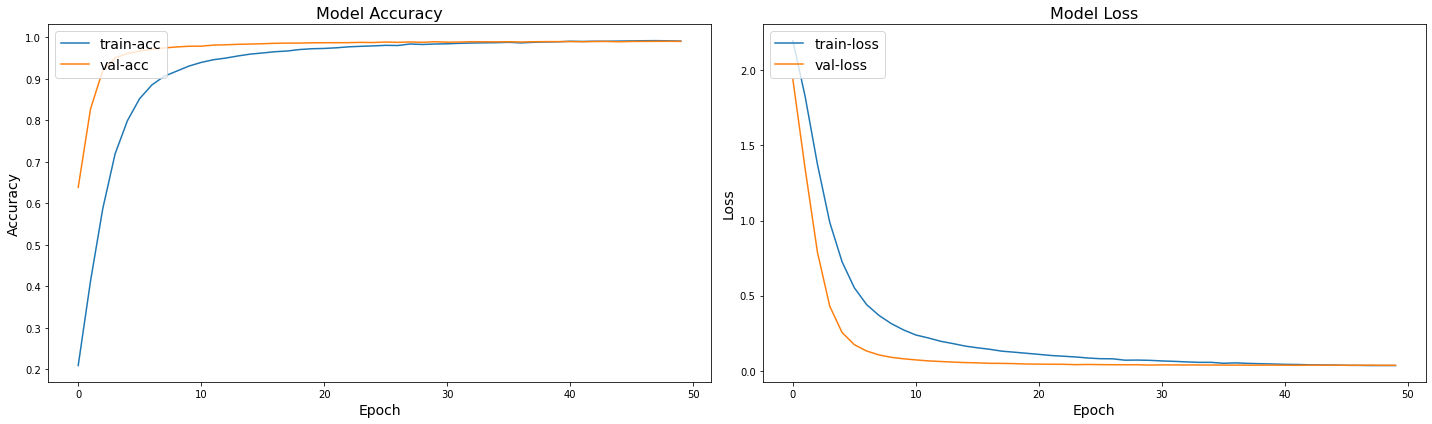

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,6))

axs[0].plot(np.arange(len(history['acc']['train'])), history['acc']['train'])
axs[0].plot(np.arange(len(history['acc']['val'])), history['acc']['val'])
axs[0].set_title('Model Accuracy', fontsize = 16)
axs[0].set_ylabel('Accuracy', fontsize = 14)
axs[0].set_xlabel('Epoch', fontsize = 14)
axs[0].legend(['train-acc', 'val-acc'], loc='upper left', fontsize = 14)

axs[1].plot(np.arange(len(history['loss']['train'])), history['loss']['train'])
axs[1].plot(np.arange(len(history['loss']['val'])), history['loss']['val'])
axs[1].set_title('Model Loss', fontsize = 16)
axs[1].set_ylabel('Loss', fontsize = 14)
axs[1].set_xlabel('Epoch', fontsize = 14)
axs[1].legend(['train-loss', 'val-loss'], loc='upper left', fontsize = 14)

plt.tight_layout()
plt.show()

In [10]:
best_model = VGG16.load('./vgg16-sgd-mnist.pt').to(device)

In [11]:
best_model.eval()
test_iterator = tqdm(test_loader, leave=True)
running_test_loss, running_test_acc = 0.0, 0.0
for tidx, (test_images, test_labels) in enumerate(test_iterator):
    with torch.no_grad():
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_outputs = best_model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        test_acc = ((test_outputs.argmax(dim=1) == test_labels).float().mean())

        running_test_loss += test_loss.item()
        running_test_acc += test_acc.item()

        val_iterator.set_description('(Test)')
        val_iterator.set_postfix(test_loss=test_loss.item(), test_acc=test_acc.item())

total_test_acc = running_test_acc/len(test_loader)
total_test_loss = running_test_loss/len(test_loader)

print(f'>> Result:\tTest loss = {total_test_loss:.5f} \t Test Acc = {total_test_acc:.5f}')

100%|██████████| 157/157 [00:02<00:00, 64.68it/s]

>> Result:	Test loss = 0.03571 	 Test Acc = 0.99154
